#  U-Net Test: CT Bone Segmentation

In [ ]:
from PIL import Image
import numpy as np
import scipy.io as scio
import glob
import torch

import torch.nn as nn
import torch.nn.functional as F
import os
import random
from tqdm import tqdm

from torch.utils.data import DataLoader, random_split
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

from utils import match_files_from_patient, readBinImage, readUCharImage
from dataset import CTMaskDataset
from model import UNet
from train import train_net
from eval import eval_net
from losses import FocalLoss, MixedLoss, dice, IoU
from predict import predict

import imgaug as iaa
from datetime import datetime
import pickle

## Define Datasets
Get the CT and label mask files into Datasets.

In [ ]:
patient_idxs = [1, 3, 4]
ct_data = []
for idx in patient_idxs:
    for day_selection in range(1,4):
        matched_data = match_files_from_patient(idx, 
                                                day_selection, 
                                                mode='CT_SPINE',
                                                no_empties=True)
        ct_data.extend(matched_data)

random.shuffle(ct_data)

train_set_size = 500
val_set_size = int(0.2 * train_set_size)
train_data = ct_data[0:train_set_size]
val_data = ct_data[train_set_size:train_set_size + val_set_size]

train_dataset = CTMaskDataset(train_data, augment=True)
val_dataset = CTMaskDataset(val_data, augment=False)

batch_size = 2
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=8)

val_loader = DataLoader(val_dataset, 
                        batch_size=batch_size, 
                        shuffle=True, 
                        num_workers=8)

## Dataset verification
Check the dataset containers for correct data and shape.

In [ ]:
idx = np.random.choice(len(train_dataset))
sample_data = train_dataset[idx]

print('data sample:')
print(sample_data)

ct = sample_data['data']
print('ct image shape: ' + str(ct.shape))

mask = sample_data['label']
print('mask image shape: ' + str(mask.shape))

fig = plt.Figure(figsize=(10,20))
ax = plt.subplot(1,2,1)
ax.imshow(ct[0,:,:])
bx = plt.subplot(1,2,2)
bx.imshow(mask[0,:,:])

plt.show()

## Create datalog folder

In [ ]:
current_datetime = datetime.now().strftime('%Y.%m.%d-%H.%M.%S')
output_directory = 'trainlog-' + current_datetime
if not os.path.isdir(output_directory):
    os.makedirs(output_directory)

## Training initialization
Define hyperparameters for learning, loss function, optimizer, etc...

In [ ]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

# model hyperparameters
lr_model = 0.0003
decay_step_size = 500
focal_gain = 10.0

# declare model
channel_in, num_classes = 1, 1
model = UNet(channel_in, num_classes)
model.to(device)

# learning schema
criterion = MixedLoss(focal_gain, gamma=2)

optimizer = torch.optim.Adam(model.parameters(), lr=lr_model)

learning_scheduler = lr_scheduler.StepLR(optimizer, step_size=decay_step_size, gamma=0.1)

num_epochs = 1
ckpt_save_interval = 2

# loss log initialization
train_losses = []
val_losses = []
best_score = 0.0


## Training loop
General training scheme with validation statistics recorded per epoch. 

In [ ]:
for epoch in range(num_epochs):
    # run training step
    train_loss = train_net(model, 
                           device, 
                           train_loader,
                           batch_size,
                           criterion, 
                           optimizer,
                           learning_scheduler,
                           epoch,
                           print_log=True)

    # run validation step
    val_loss = eval_net(model, 
                        device, 
                        val_loader, 
                        print_log=True)

    # save best models
    if val_loss[0] > best_score:
        best_score = val_loss[0]
        torch.save(model.state_dict(), 
                   '{}/unet_model_{}.pt'.format(output_directory, epoch))

    # record losses to logs
    train_losses.append(train_loss)
    val_losses.append(val_loss)

## Training charts
Not sure if this works right now.

In [ ]:
dice_scores, iou_scores = zip(*val_losses)
n = range(0, len(dice_scores))
fig = plt.figure(figsize=(12,8))
plt.plot(n, dice_scores, label='dice')
plt.plot(n, iou_scores, label='iou')
plt.grid('on')
plt.legend()

## Inference test
Grab a random CT image from the loaded dataset and performs a prediction!

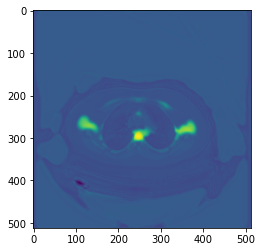

In [214]:
ct_file = ct_data[random.randint(1,len(ct_data))][0]
prediction = predict(model, ct_file)
prediction = prediction[0,0,:,:]
mask = torch.sigmoid(prediction).detach().cpu().numpy()
plt.imshow(mask, cmap='cividis')
